# Dask, Pandas, and Numpy Module Imports

Need to import each of the dependencies used throughout the notebook. Doing this up front gives us the environment we need for the rest of execution.

In [2]:
#imports
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import pandas as pd
import numpy as np
import dask_ml

#prefs
pd.set_option('max_columns', None)


# Dask Client Setup

If Dask is already running, we need to kill it so we can start a fresh session. Once we have a blank slate, we can start up a new client.

In [3]:
# Close existing dask connection one already exists and open a new one
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)
    

name 'client' is not defined


In [4]:
# Create new connection (old one is now gone if it existed before)
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

Client Scheduler: tcp://127.0.0.1:44807 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 12.26 GiB


# Data Ingest

Use Dask to read in the CSV files representing the netflow data from the IDS dataset. Uncomment the code associated with the variable 'data3' to see experimental feature for identifying insider threats.

Note: The data has been pre-downloaded from AWS S3 data lakes. In a production system, we would likely use Dask to directly interface with these data lakes rather than use cached files on the local file system.

In [5]:
data1 = dd.read_csv("ids-data/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
       'Active Std': 'float64', 'Label': 'str'})

data2 = dd.read_csv("ids-data/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
       'Active Std': 'float64', 'Label': 'str'})

#data3 = dd.read_csv("ids-data/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
#       'Active Std': 'float64', 'Label': 'str'})

data = data1.append(data2)#.append(data3)


# Data Cleanup

Use Dask to perform distributed data cleanup. There are a few problems with the IDS dataset out-of-the-box:

1. Timestamps do not indicate whether they are A.M. or P.M. Based on the times of the experiments, we believe that any time prior to 8:00 is P.M.
1. Timestamps are ingested as a string. Need to convert them to an integer data type.
1. Some columns (Flow Byts/s and Flow Pkts/s) contain values that are outside the acceptable range for the isolation forest algorithm (float32). We cap values in these columns at float32's maximum value so that we can still honor that the value is supposed to be large.
1. Labels will be easier to aggregate if we treat them as a summable type (e.g., int32). This allows us to determine if any malicious records exist post-aggregation

# Creating Time Windows

We achieve better results when we aggregate data in our dataset based on time. We cluster records in 10-minute chunks and will use the isolation forest algorithm to look for outliers across these time windows, as opposed to in individual netflow records. To do this, we modify timestamps to represent not seconds since epoch, but rather 10-minute chunks since epoch.

In [6]:
%%time

# Import our helper function
from date_util import time_cleaner

# Clean up the timestamp field and convert it from nanoseconds to seconds
data['Timestamp'] = data['Timestamp'].apply(lambda x: time_cleaner(x), meta=('Timestamp', 'str'))
data['Timestamp'] = dd.to_datetime(data.Timestamp, format='%d/%m/%Y %H:%M:%S').astype(np.int64)
data['Timestamp'] = (data['Timestamp'] / 1000000000).astype(np.int64)

# There is some data that need to be dropped because they are corrupted. Easiest way to tell is if the
# timestamp is completely off. We'll say anything before January 1 2018 needs to be dropped
import datetime
timestamp_cutoff = np.int64(datetime.datetime(2018, 1, 1).timestamp())
data = data[data.Timestamp > timestamp_cutoff]

# Divide the timestamps into 10-minute chunks
data['Timestamp'] = (data['Timestamp'] / 600).astype(np.int64)

# Prevent overflow in columns that exceed accepted values in isolation forest algorithm
max_val = np.finfo(np.float32).max
data['Flow Byts/s'] = data['Flow Byts/s'].astype(np.float32)
data['Flow Pkts/s'] = data['Flow Pkts/s'].astype(np.float32)

# Modify label to use integers (0 for benign, else 1). Allows us to 'sum' labels when we
# group time chunks together
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1, meta=('Label', 'int32'))

# Persist the cleaned data into distributed RAM
clean_data = data.persist()
print(f'number of netflow records = {len(clean_data)}')


number of netflow records = 2097145
CPU times: user 3.19 s, sys: 873 ms, total: 4.06 s
Wall time: 37.4 s


# Aggregation

Use Dask to perform distributed aggregation of records.

Aggregate netflow records by the timestamp, which has been modified to represent which 10-minute chunk the data came from. In the aggregation, use various functions (e.g., sum, mean, count) to replace values in columns of interest.

In [7]:
# Possible features
# Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label

# Group by time
agg_data = clean_data.groupby(['Timestamp']).agg(    
    {
        'Flow Duration': ['mean', 'count'],
        'Tot Fwd Pkts': ['sum'],
        'Tot Bwd Pkts': ['sum'],
        'TotLen Fwd Pkts' : ['sum'],
        'TotLen Bwd Pkts' : ['sum'],
        'Fwd Pkt Len Max' : ['mean'],
        'Fwd Pkt Len Min' : ['mean'],
        'Fwd Pkt Len Mean' : ['mean'],
        'Fwd PSH Flags' : ['sum'],
        'Bwd PSH Flags' : ['sum'],
        'Fwd URG Flags' : ['sum'],
        'Bwd URG Flags' : ['sum'],
        'FIN Flag Cnt' : ['sum'],
        'SYN Flag Cnt' : ['sum'],
        'RST Flag Cnt' : ['sum'],
        'PSH Flag Cnt' : ['sum'],
        'ACK Flag Cnt' : ['sum'],
        'URG Flag Cnt' : ['sum'],
        'CWE Flag Count' : ['sum'],
        'ECE Flag Cnt' : ['sum'],
        'Pkt Size Avg' : ['mean'],
        'Fwd IAT Mean' : ['mean'],
        'Bwd IAT Mean' : ['mean'],
        'Idle Min' : ['mean'],
        'Label': ['sum']
    }
).compute()

In [8]:

print(f"Num malicious time chunks = {len(agg_data[agg_data['Label']['sum'] > 0])}")
print(f"Num benign time chunks = {len(agg_data)}")


Num malicious time chunks = 31
Num benign time chunks = 114


In [9]:
# Get labels for the dataset and drop from the training data so it does not influence classification
agg_labels = agg_data['Label']['sum']
agg_train = agg_data.drop('Label', axis=1)

# Reset the index so that timestamp will be included in analysis
agg_train = agg_train.reset_index()


/home/mwdehn/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


# Perform Classification

Switch from Dask to pandas/sklearn.

Use the isolation forest implementation used by sklearn. This will automatically return data to pandas via the sklearn interface. 

In [10]:
%%time

# Fit and predict based on the FTP-BruteForce attacks
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0)

clf.fit(agg_train)
y_predict = clf.predict(agg_train)

CPU times: user 1.47 s, sys: 382 ms, total: 1.85 s
Wall time: 1.69 s


precision = 0.8275862068965517; recall = 0.7741935483870968; accuracy = 0.8947368421052632


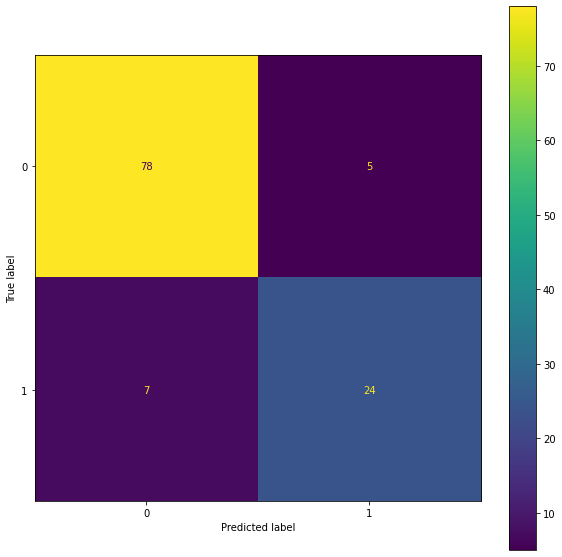

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

# Define what our predicated and actual labels were
predicted = y_predict
actual = [1 if y == 0 else -1 for y in agg_labels]

# Collect some performance metrics and report them
precision = precision_score(actual, predicted, pos_label=-1) 
recall = recall_score(actual, predicted, pos_label=-1) 
accuracy = accuracy_score(actual, predicted) 
print(f'precision = {precision}; recall = {recall}; accuracy = {accuracy}')

#setup figure size
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

# Show confusion matrix
cm = confusion_matrix(actual, predicted, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

# Appendix

Just some extra code to see which times of day we flagged as having attacks occur

In [12]:
import datetime
times = [datetime.datetime.fromtimestamp(x * 600) for x in agg_train['Timestamp']]

ground_truth = [times[idx] for idx, val in enumerate(actual) if val == -1]
mal = [times[idx] for idx, val in enumerate(predicted) if val == -1]

print(set(ground_truth) & set(mal))

{datetime.datetime(2018, 2, 14, 9, 30), datetime.datetime(2018, 2, 14, 6, 30), datetime.datetime(2018, 2, 14, 9, 0), datetime.datetime(2018, 2, 14, 5, 30), datetime.datetime(2018, 2, 14, 6, 40), datetime.datetime(2018, 2, 14, 6, 0), datetime.datetime(2018, 2, 14, 9, 40), datetime.datetime(2018, 2, 15, 6, 30), datetime.datetime(2018, 2, 14, 5, 40), datetime.datetime(2018, 2, 14, 6, 20), datetime.datetime(2018, 2, 14, 9, 50), datetime.datetime(2018, 2, 14, 10, 30), datetime.datetime(2018, 2, 14, 7, 0), datetime.datetime(2018, 2, 14, 10, 20), datetime.datetime(2018, 2, 14, 5, 50), datetime.datetime(2018, 2, 14, 10, 10), datetime.datetime(2018, 2, 14, 9, 20), datetime.datetime(2018, 2, 14, 9, 10), datetime.datetime(2018, 2, 15, 4, 50), datetime.datetime(2018, 2, 15, 6, 20), datetime.datetime(2018, 2, 14, 10, 0), datetime.datetime(2018, 2, 14, 6, 50), datetime.datetime(2018, 2, 15, 6, 0), datetime.datetime(2018, 2, 15, 6, 10)}
